# DCGAN PyTorch Implementation

In this notebook we will be firstly implementing DCGAN for cifar-10, and the applying it to collected Minecraft textures. The resource used for the first step was: 

- Blog tutorial on Cifar 
(https://debuggercafe.com/implementing-deep-convolutional-gan-with-pytorch/)
- PyTorch tut on faces (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

## Imports

In [1]:
import torch
import torch.nn as nn
from torchvision.utils import save_image

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets

from torch.utils.data import DataLoader

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import matplotlib
matplotlib.style.use('ggplot')

## DCGAN Model

In [3]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz  # noise vector to be used as input
        
        # A sequential container, modules added in order passed
        self.main = nn.Sequential(
            
            # Conv 1
            nn.ConvTranspose2d(nz, 512, kernel_size=4, 
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # Conv 2
            nn.ConvTranspose2d(512, 256, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Conv 3
            nn.ConvTranspose2d(256, 128, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Conv 4
            nn.ConvTranspose2d(128, 64, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Conv 5 (Flatten to image)
            nn.ConvTranspose2d(64, 3, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.Tanh()       
        )
        
    def forward(self, input):
        return self.main(input)

In [4]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # Conv 1
            nn.Conv2d(3, 64, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Conv 2
            nn.Conv2d(64, 128, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Conv 3
            nn.Conv2d(128, 256, kernel_size=4,  
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Conv 4
            nn.Conv2d(256, 512, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Conv 5 (Final layer for fake or real)
            nn.Conv2d(512, 1, kernel_size=4, 
                      stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

## Utils

In [5]:
# Creating real labels by batch size
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)


# Creating fake labels by batch size
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


# Creating noise tensor by sample/batch size and latent vector size
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, 1, 1).to(device)

In [6]:
def save_generator_image(image, path):
    save_image(image, path, normalize=True)

In [7]:
# Initializes model weights from dist with mu=0, s=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Data

Hyperparameters

In [8]:
# Dimensions
image_size = 64 # we need to resize image to 64x64
nz = 100 # latent vector size
batch_size = 128 # loading data in batches

In [9]:
# Resizes image and normalizes values
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

In [10]:
# prepare the data
train_data = datasets.CIFAR10(
    root='../input/cifar10',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## Training

Hyperparameters

In [11]:
# Training
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train

In [12]:
# Initialise models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Initialize weights (and print)
print(generator.apply(weights_init))
print(discriminator.apply(weights_init))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# loss function
criterion = nn.BCELoss()  # Binary Cross Entropy

# Losses per epoch to later plot
losses_g = []
losses_d = []

In [14]:
# Train the discriminator for an epoch
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    
    # Get real and fake label vectors
    real_label = label_real(b_size) 
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    
    # Get the outputs by doing real data forward pass
    output_real = discriminator(data_real)
    output_real = torch.squeeze(output_real)
    real_label = torch.squeeze(real_label)
    loss_real = criterion(output_real, real_label)
    
    # Get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake)
    output_fake = torch.squeeze(output_fake)
    fake_label = torch.squeeze(fake_label)
    loss_fake = criterion(output_fake, fake_label)
    
    # Compute gradients of real and fake losses 
    loss_real.backward()
    loss_fake.backward()
    
    # update discriminator parameters
    optimizer.step()
    
    return loss_real + loss_fake

In [15]:
# Train the generator for an epoch
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    
    # Get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    
    # Output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake)
    output = torch.squeeze(output)
    real_label = torch.squeeze(real_label)
    loss = criterion(output, real_label)
    
    # compute gradients of loss
    loss.backward()
    
    # update generator parameters
    optimizer.step()
    
    return loss 

In [16]:
# Create the noise vector right before training
noise = create_noise(sample_size, nz)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1 of 25
Generator loss: 7.21464968, Discriminator loss: 0.58622319


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2 of 25
Generator loss: 4.13559771, Discriminator loss: 0.64304459


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3 of 25
Generator loss: 3.59865570, Discriminator loss: 0.64647627


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4 of 25
Generator loss: 3.43412971, Discriminator loss: 0.68314749


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5 of 25
Generator loss: 2.96139264, Discriminator loss: 0.73248655


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6 of 25
Generator loss: 2.69938183, Discriminator loss: 0.76110506


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7 of 25
Generator loss: 3.03893495, Discriminator loss: 0.70324016


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8 of 25
Generator loss: 3.15141153, Discriminator loss: 0.68635684


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9 of 25
Generator loss: 3.01824641, Discriminator loss: 0.75095117


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10 of 25
Generator loss: 3.16849589, Discriminator loss: 0.64425343


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11 of 25
Generator loss: 3.74056840, Discriminator loss: 0.54238755


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12 of 25
Generator loss: 3.86910987, Discriminator loss: 0.53283632


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13 of 25
Generator loss: 2.57814956, Discriminator loss: 0.82496893


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14 of 25
Generator loss: 3.33912420, Discriminator loss: 0.61885667


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15 of 25
Generator loss: 3.76139951, Discriminator loss: 0.53880072


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16 of 25
Generator loss: 2.45588517, Discriminator loss: 0.78930873


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17 of 25
Generator loss: 2.82064056, Discriminator loss: 0.73328847


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18 of 25
Generator loss: 3.78760719, Discriminator loss: 0.47719571


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19 of 25
Generator loss: 3.30044508, Discriminator loss: 0.57910454


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20 of 25
Generator loss: 3.61769176, Discriminator loss: 0.55189109


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 21 of 25
Generator loss: 2.81836247, Discriminator loss: 0.73934454


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22 of 25
Generator loss: 3.18844604, Discriminator loss: 0.58256906


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23 of 25
Generator loss: 3.23357534, Discriminator loss: 0.64675945


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24 of 25
Generator loss: 2.89158702, Discriminator loss: 0.66441137


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 25 of 25
Generator loss: 4.75483370, Discriminator loss: 0.24770172
DONE TRAINING


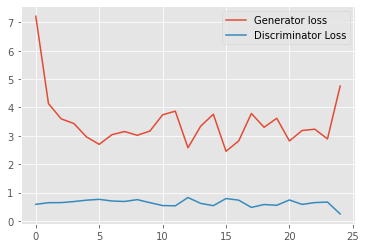

In [17]:
# Training loop over multiple epochs
for epoch in tqdm(range(epochs)):
    loss_g = 0.0
    loss_d = 0.0
    
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
        
    # Final forward pass through generator to create fake data after one epoch
    generated_img = generator(noise).cpu().detach()
    
    # Save the generated results to disk
    save_generator_image(generated_img, f"../outputs/cifar10/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    
# Save the model
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), '../outputs/cifar10/generator.pth')

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('../outputs/cifar10/loss.png')
plt.show()